# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
### Data exploration visualization
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import csv
from sklearn.utils import shuffle
import skimage as sk
from skimage import util
from skimage import transform
from scipy import ndarray
import glob
import cv2
import imutils
from keras import backend as K
import seaborn as sns
sns.set_style("dark")

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Load pickled data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test  = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test['features'],  test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test)  == len(y_test))


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Basic Summyry of the Data Set

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train, return_counts=False).shape[0]

n_total    = n_train + n_validation + n_test
train_perc = round(n_train / n_total * 100)
valid_perc = round(n_validation / n_total * 100)
test_perc  = round(n_test / n_total * 100)


print(
    f"Number of training examples   = {n_train} => {train_perc}%"'\n'
    f"Number of validation examples = {n_validation}  =>  {valid_perc}%"'\n'
    f"Number of testing examples    = {n_test} => {test_perc}%"'\n'
    f"Image data shape (RGB)        = {image_shape}"'\n'
    f"Number of uinque classes      = {n_classes}"'\n'
      )


Number of training examples   = 34799 => 67%
Number of validation examples = 4410  =>  9%
Number of testing examples    = 12630 => 24%
Image data shape (RGB)        = (32, 32, 3)
Number of uinque classes      = 43



In [5]:
# Read ClassId and SignName and print it
ClassId_SignName = {}

with open('signnames.csv') as signnames_file:
    csv_reader = csv.reader(signnames_file)
    for line in csv_reader:
        ClassId_SignName[line[0]] = line[1]
for key in range(len(ClassId_SignName)-1):
    print('ClassID',key,':', ClassId_SignName[str(key)])

ClassID 0 : Speed limit (20km/h)
ClassID 1 : Speed limit (30km/h)
ClassID 2 : Speed limit (50km/h)
ClassID 3 : Speed limit (60km/h)
ClassID 4 : Speed limit (70km/h)
ClassID 5 : Speed limit (80km/h)
ClassID 6 : End of speed limit (80km/h)
ClassID 7 : Speed limit (100km/h)
ClassID 8 : Speed limit (120km/h)
ClassID 9 : No passing
ClassID 10 : No passing for vehicles over 3.5 metric tons
ClassID 11 : Right-of-way at the next intersection
ClassID 12 : Priority road
ClassID 13 : Yield
ClassID 14 : Stop
ClassID 15 : No vehicles
ClassID 16 : Vehicles over 3.5 metric tons prohibited
ClassID 17 : No entry
ClassID 18 : General caution
ClassID 19 : Dangerous curve to the left
ClassID 20 : Dangerous curve to the right
ClassID 21 : Double curve
ClassID 22 : Bumpy road
ClassID 23 : Slippery road
ClassID 24 : Road narrows on the right
ClassID 25 : Road work
ClassID 26 : Traffic signals
ClassID 27 : Pedestrians
ClassID 28 : Children crossing
ClassID 29 : Bicycles crossing
ClassID 30 : Beware of ice/sno

### Include an exploratory visualization of the dataset

label:7


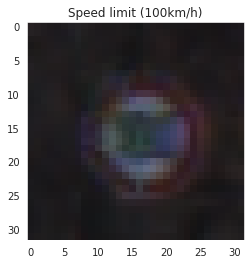

In [6]:
# Sample image with label and sign name
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(4,4))
plt.imshow(image)
plt.title(ClassId_SignName[str(y_train[index])])
print(f'label:{y_train[index]}')

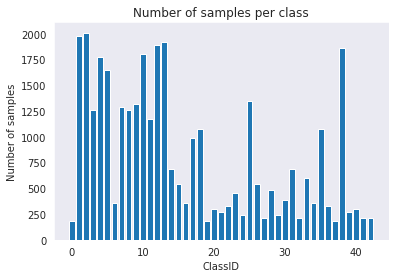

In [7]:
# Number of samples per class for the training data set
x,y = np.unique(y_train, return_counts=True)
plt.bar(x,y)
plt.title('Number of samples per class')
plt.xlabel('ClassID')
plt.ylabel('Number of samples')
plt.show()

In [8]:
# Data augmentation for classes with less than 2000 images: random rotation and random noise

def map_array(f, x):
    return np.array(list(map(f, x.astype(np.float32))))

def rotate_image(image):
    """Generate a rotated image with a random rotation angle"""
    angle = random.randint(-20., 20.)
    rotated = imutils.rotate(image, angle, scale=1)
    rotated = np.clip(rotated, 0, 255)
    return rotated.astype(int)

def noise_image(image):
    """Generate an image with a random gaussian noise"""
    row,col,ch= image.shape
    mean = random.randint(-10.0, 10.0)
    var = random.randint(0.0, 100.0)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(int)


In [11]:
# pic classes with less that 990 sample images
new_data = {x:y for x,y in zip(x,y) if y < 990}

# augment images and add them to the training data set
for label in new_data.keys():
    X_bunch_noise = X_bunch_noise_mult = X_bunch_rot = X_bunch_rot_mult = np.array([[[]]])
    n_samples = new_data[label]
    n_to_2000 = 2000 - n_samples
    n_to_2000_half = round(n_to_2000 / 2)
    mult_orig_samples = round(n_to_2000_half / n_samples)

    index = np.where(y_train == label)
    bunch_orig_images = X_train[index]

    X_bunch_noise = map_array(noise_image,bunch_orig_images)
    X_bunch_noise_mult = X_bunch_noise
        for multiplier in range(mult_orig_samples-1):
        X_bunch_noise_mult = np.concatenate((X_bunch_noise_mult, X_bunch_noise), axis=0)

    X_bunch_rot = map_array(rotate_image,bunch_orig_images)
    X_bunch_rot_mult = X_bunch_rot
    for multiplier in range(mult_orig_samples-1):
        X_bunch_rot_mult = np.concatenate((X_bunch_rot_mult, X_bunch_rot), axis=0)

    y_bunch = [label for x in range(n_samples * 2 * mult_orig_samples)]

    X_train = np.concatenate((X_train,X_bunch_noise_mult,X_bunch_rot_mult) ,axis=0)
    y_train = np.concatenate((y_train,y_bunch))

---------------------------------------------------
X_train shape: (36599, 32, 32, 3), y_train shape: (36599,)
mult_orig_samples: 5
len(X_bunch_noise_mult)): 900
len(X_bunch_rot_mult)): 900
n_samples: 180, n_to_2000: 1820, n_to_2000_half: 910
y_bunch[:4]: [0, 0, 0, 0], len(y_bunch): 1800
---------------------------------------------------
---------------------------------------------------
X_train shape: (38039, 32, 32, 3), y_train shape: (38039,)
mult_orig_samples: 2
len(X_bunch_noise_mult)): 720
len(X_bunch_rot_mult)): 720
n_samples: 360, n_to_2000: 1640, n_to_2000_half: 820
y_bunch[:4]: [6, 6, 6, 6], len(y_bunch): 1440
---------------------------------------------------
---------------------------------------------------
X_train shape: (39419, 32, 32, 3), y_train shape: (39419,)
mult_orig_samples: 1
len(X_bunch_noise_mult)): 690
len(X_bunch_rot_mult)): 690
n_samples: 690, n_to_2000: 1310, n_to_2000_half: 655
y_bunch[:4]: [14, 14, 14, 14], len(y_bunch): 1380
-------------------------

---------------------------------------------------
X_train shape: (75597, 32, 32, 3), y_train shape: (75597,)
mult_orig_samples: 4
len(X_bunch_noise_mult)): 840
len(X_bunch_rot_mult)): 840
n_samples: 210, n_to_2000: 1790, n_to_2000_half: 895
y_bunch[:4]: [41, 41, 41, 41], len(y_bunch): 1680
---------------------------------------------------
---------------------------------------------------
X_train shape: (77277, 32, 32, 3), y_train shape: (77277,)
mult_orig_samples: 4
len(X_bunch_noise_mult)): 840
len(X_bunch_rot_mult)): 840
n_samples: 210, n_to_2000: 1790, n_to_2000_half: 895
y_bunch[:4]: [42, 42, 42, 42], len(y_bunch): 1680
---------------------------------------------------


In [13]:
# further expanding the training data
X_train_noise = map_array(noise_image,X_train)
X_train_ret = map_array(rotate_image,X_train)

X_train = np.concatenate((X_train,X_train_noise,X_train_ret) ,axis=0)
y_train = np.concatenate((y_train,y_train,y_train))

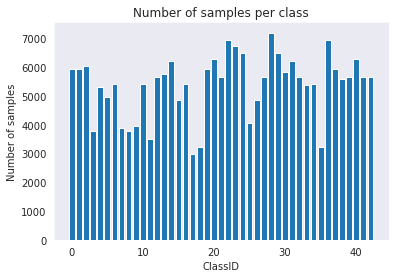

In [14]:
# Number of samples per class for the training data set
x,y = np.unique(y_train, return_counts=True)
plt.bar(x,y)
plt.title('Number of samples per class')
plt.xlabel('ClassID')
plt.ylabel('Number of samples')
plt.show()

In [15]:
print(f"Number of training examples after augmentation = {X_train.shape[0]}")

Number of training examples after augmentation = 231831



 Sample of every image with sign name:


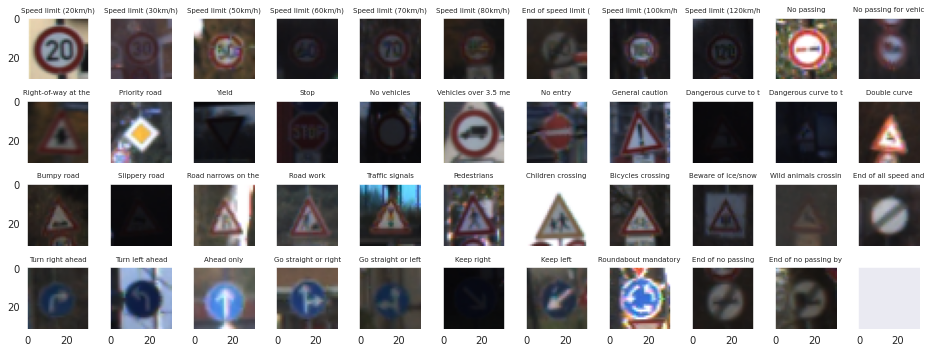

In [16]:
# Sample of every image with sign name

print()
print(' Sample of every image with sign name:')

example_images = []
for ID in range(n_classes):
    index = np.where(y_train == ID)
    example_images.append(X_train[index[0][0]])

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 11), axes_pad=0.3)

for ax, img, idx in zip(grid, example_images, range(len(example_images))):
    title =  ClassId_SignName[str(idx)]
    ax.set_title(title[:20], loc='center', fontdict={'fontsize': 7})
    ax.imshow(img)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [2]:
# Shuffle training data
X_train, y_train = shuffle(X_train, y_train)

NameError: name 'shuffle' is not defined

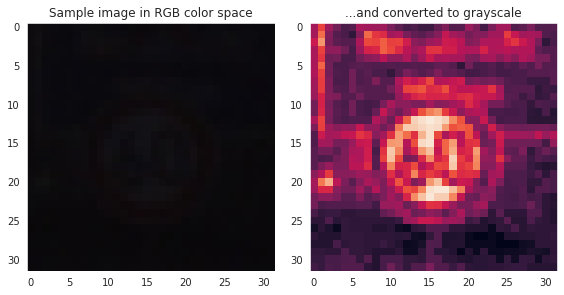

In [18]:
# Preprocessing: convert to grayscale

def rgb2gray(rgb):
    rgb = rgb.astype(np.float64)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

X_train_gray = rgb2gray(X_train)
X_valid_gray = rgb2gray(X_valid)
X_test_gray  = rgb2gray(X_test )

f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title('Sample image in RGB color space')
ax1.imshow(X_train[0])
ax2.set_title('...and converted to grayscale')
ax2.imshow(X_train_gray[0])
plt.tight_layout()

In [19]:
# Preprocessing: normalization

def standardise(images):
    pixels = np.asarray(images)
    pixels = pixels.astype('float64')
    mean, std = pixels.mean(), pixels.std() # calculate global mean and standard deviation
    # positive global Standardization of pixels
    pixels = (pixels - mean) / std
    #pixels = np.clip(pixels, -1.0, 1.0) # clip pixel values to [-1,1]
    #pixels = (pixels + 1.0) / 2.0 # shift from [-1,1] to [0,1] with 0.5 mean
    return pixels

X_train_gray_stand = standardise(X_train_gray)
X_valid_gray_stand = standardise(X_valid_gray)
X_test_gray_stand  = standardise(X_test_gray )

Mean of training set with standardised grayscale images: 0.000, and its standard deviation: 1.000
Minimal value: -1.230, Maximal value: 2.710


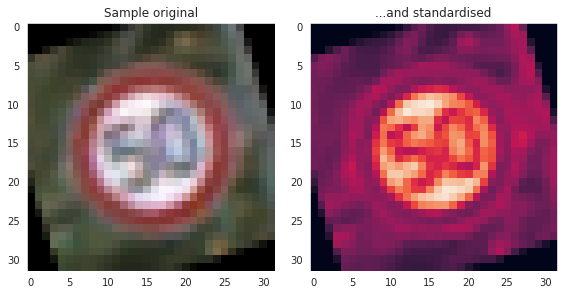

In [20]:
# check mean, stdev, min, max
mean, std = X_train_gray_stand.mean(), X_train_gray_stand.std()
print('Mean of training set with standardised grayscale images: %.3f, and its standard deviation: %.3f' % (mean, std))
print('Minimal value: %.3f, Maximal value: %.3f' % (X_train_gray_stand.min(), X_train_gray_stand.max()))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title('Sample original')
ax1.imshow(X_train[200000])
ax2.set_title('...and standardised')
ax2.imshow(X_train_gray_stand[200000])
plt.tight_layout()
f.savefig(f'examples/original_and_standardized.png')

2
(array([    50,    223,    245, ..., 231752, 231774, 231789]),)


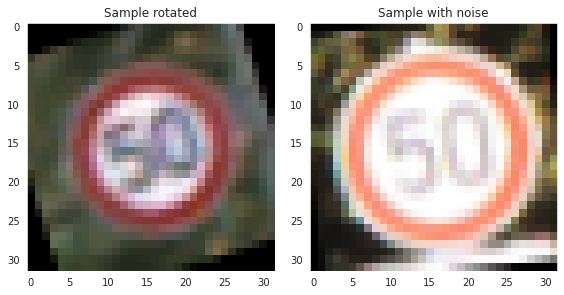

In [21]:
print(y_train[200000])
index = np.where(y_train == y_train[200000])
print(index)
#print(X_train[np.where(y_train == ID)])
#print(ClassId_SignName[str(y_train[200000])])
#print(X_train[y_train[200000]])
#index = np.where(y_train == ID))
#X_train[index].squeeze()
#plt.imshow(X_train[y_train[ClassId_SignName[str(y_train[200000])]]])
f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title('Sample rotated')
ax1.imshow(X_train[200000])
ax2.set_title('Sample with noise')
ax2.imshow(X_train[index[0][0]])
plt.tight_layout()


In [22]:
# reshape to net input shape
X_train = np.reshape(X_train_gray_stand, (len(X_train),32,32,1))
X_valid = np.reshape(X_valid_gray_stand, (len(X_valid),32,32,1))
X_test  = np.reshape(X_test_gray_stand,  (len(X_test), 32,32,1))
print(f'X_train shape: {X_train.shape}')

X_train shape: (231831, 32, 32, 1)


### Model Architecture

### Train, Validate and Test the Model

In [23]:
# Input parameter for training
K.clear_session()
EPOCHS = 30
BATCH_SIZE = 128

In [24]:
# This CNN is based on lenet invented by Yann LeCun.
# It has been optimized by adding dropouts between the fully connected layers.

def traffic_sign_classifier_cnn(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1   = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1   = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2   = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0     = flatten(conv2)
    
    # Dropout
    fc0     = tf.nn.dropout(fc0, keep_prob = keep_probability)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W   = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b   = tf.Variable(tf.zeros(120))
    fc1     = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1     = tf.nn.relu(fc1)
    
    # Dropout
    fc1     = tf.nn.dropout(fc1, keep_prob = keep_probability)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W   = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b   = tf.Variable(tf.zeros(84))
    fc2     = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2     = tf.nn.relu(fc2)
    
    # Dropout
    fc2     = tf.nn.dropout(fc2, keep_prob = keep_probability)

    #Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W   = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b   = tf.Variable(tf.zeros(43))
    logits  = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [25]:
# define placeholders

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_probability = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [26]:
# calculate the logits and optimize

rate = 0.0005

logits = traffic_sign_classifier_cnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [27]:
# calculate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [28]:
# function for validation

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [29]:
# run session

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    training_accuracy_lst = []
    validation_accuracy_lst = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_probability: 0.5})

        training_accuracy = evaluate(X_train, y_train)    
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        training_accuracy_lst.append(training_accuracy)
        validation_accuracy_lst.append(validation_accuracy)
        
    saver.save(sess, './traffic_sign_classifier_cnn')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.817
Validation Accuracy = 0.746

EPOCH 2 ...
Training Accuracy = 0.889
Validation Accuracy = 0.847

EPOCH 3 ...
Training Accuracy = 0.923
Validation Accuracy = 0.896

EPOCH 4 ...
Training Accuracy = 0.938
Validation Accuracy = 0.905

EPOCH 5 ...
Training Accuracy = 0.947
Validation Accuracy = 0.913

EPOCH 6 ...
Training Accuracy = 0.953
Validation Accuracy = 0.930

EPOCH 7 ...
Training Accuracy = 0.956
Validation Accuracy = 0.931

EPOCH 8 ...
Training Accuracy = 0.963
Validation Accuracy = 0.937

EPOCH 9 ...
Training Accuracy = 0.964
Validation Accuracy = 0.940

EPOCH 10 ...
Training Accuracy = 0.966
Validation Accuracy = 0.943

EPOCH 11 ...
Training Accuracy = 0.969
Validation Accuracy = 0.947

EPOCH 12 ...
Training Accuracy = 0.970
Validation Accuracy = 0.947

EPOCH 13 ...
Training Accuracy = 0.970
Validation Accuracy = 0.948

EPOCH 14 ...
Training Accuracy = 0.973
Validation Accuracy = 0.945

EPOCH 15 ...
Training Accuracy = 0.973
Valid

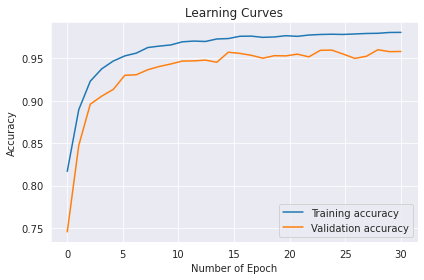

In [30]:
# plot accuracy for training and validation

x_values = np.linspace(0, EPOCHS, EPOCHS)
#x_values = np.log(x_values)
plt.plot(x_values, training_accuracy_lst, label="Training accuracy")
plt.plot(x_values, validation_accuracy_lst, label="Validation accuracy")
plt.title('Learning Curves')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.tight_layout()
plt.grid()
#plt.savefig('examples/accuracy.png')
plt.show()

In [31]:
# Use model for final test on the testing examples
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_sign_classifier_cnn
Test Accuracy = 0.935


---

## Step 3: Test a Model on New Images

### Load and Output the Images

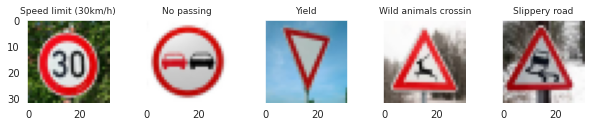

Number of examples   = 5
Shape of the images  = (32, 32, 3)



In [32]:
# Load images and plot them

new_images = glob.glob('./traffic-signs-internet/*.jpeg')
new_images = [mpimg.imread(image) for image in new_images]
new_images = [cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) for image in new_images]
new_images = np.array(new_images, dtype="int32")

new_images_labels = [1, 9, 13, 31, 23]

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.5)
for ax, img, label in zip(grid, new_images, new_images_labels):
    title =  ClassId_SignName[str(label)]
    ax.set_title(title[:20], loc='center', fontdict={'fontsize': 9})
    ax.imshow(img)
plt.show()

print(
    f"Number of examples   = {new_images.shape[0]}"'\n'
    f"Shape of the images  = {new_images[0].shape}"'\n'
      )

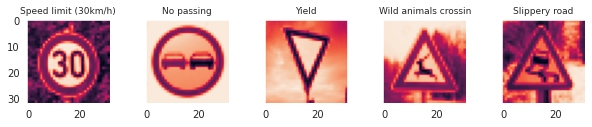

Mean of training set with standardised grayscale images: 0.000, and its standard deviation: 1.000
Minimal value: -2.095, Maximal value: 1.547


In [33]:
# convert images to grayscale and standardise
new_images_gray = rgb2gray(new_images)
new_images_gray_stand = standardise(new_images_gray)

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.5)
for ax, img, label in zip(grid, new_images_gray_stand, new_images_labels):
    title =  ClassId_SignName[str(label)]
    ax.set_title(title[:20], loc='center', fontdict={'fontsize': 9})
    ax.imshow(img)
plt.show()

mean, std = new_images_gray_stand.mean(), new_images_gray_stand.std()
print('Mean of training set with standardised grayscale images: %.3f, and its standard deviation: %.3f' % (mean, std))
print('Minimal value: %.3f, Maximal value: %.3f' % (new_images_gray_stand.min(), new_images_gray_stand.max()))

In [34]:
# reshape to net input shape
new_images = np.reshape(new_images_gray_stand, (len(new_images),32,32,1))

print(f'New_images shape: {new_images.shape}')

New_images shape: (5, 32, 32, 1)


### Predict the Sign Type for Each Image

In [35]:
# Predict the Sign for each image. Calculate the accuracy:
keep_prob = 1.
one_hot_y = tf.one_hot(y, 43)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    accuracy = sess.run(accuracy_operation, feed_dict={x: new_images, y: new_images_labels, keep_probability: keep_prob})
    print()
    print(f'The accuracy for the five new images is {accuracy*100:.0f}%.')

INFO:tensorflow:Restoring parameters from ./traffic_sign_classifier_cnn

The accuracy for the five new images is 100%.


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [36]:
# Top 5 Softmax Probabilities for each new image
keep_prob = 1.
one_hot_y = tf.one_hot(y, 43)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits = sess.run(logits, feed_dict={x: new_images, y: new_images_labels, keep_probability: keep_prob})
    top_5_probabilities = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(logits)),k=5))


INFO:tensorflow:Restoring parameters from ./traffic_sign_classifier_cnn


In [37]:
print(f'Top five probabilitys for each traffic sign:''\n'
      f'{top_5_probabilities.values}''\n\n'
      f'Top five predicted classes for each traffic sign:''\n'
      f'{top_5_probabilities.indices}'
         )

Top five probabilitys for each traffic sign:
[[9.9999976e-01 1.5734925e-07 5.7709663e-08 3.8516700e-11 1.0777301e-12]
 [9.8332572e-01 1.6674295e-02 4.6538066e-08 9.2995819e-11 1.7681146e-12]
 [9.9995005e-01 3.1581010e-05 1.3657043e-05 2.9083512e-06 4.7433900e-07]
 [9.9983728e-01 1.6274836e-04 3.4046447e-08 7.0624900e-10 2.6461972e-10]
 [5.4907835e-01 1.0528601e-01 9.5924214e-02 4.1511539e-02 3.7709415e-02]]

Top five predicted classes for each traffic sign:
[[ 1  2  0  4  7]
 [ 9 41 16 32 10]
 [13 12 15 36 35]
 [31 21 23 25 19]
 [23 30 11 42 12]]


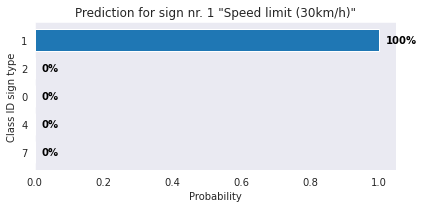

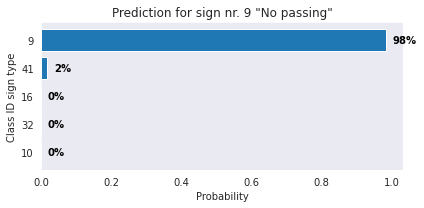

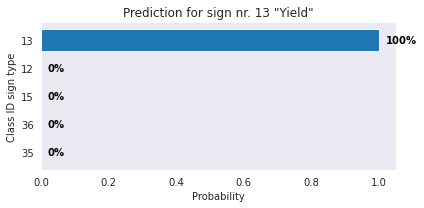

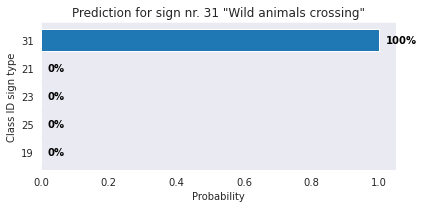

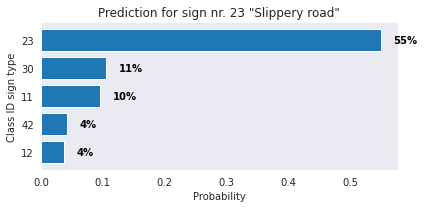

In [38]:
# Visualisation of the softmax probabilities for the five new images
y_pos = np.arange(0,5)

for img in range(len(new_images)):
    fig, ax = plt.subplots(figsize=(6,3))
    x = top_5_probabilities.values[img]
    y = top_5_probabilities.indices[img]
    label = new_images_labels[img]
    ax.invert_yaxis()
    ax.barh(y_pos,x)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y)
    ax.set_title(f'Prediction for sign nr. {label} "{ClassId_SignName[str(label)]}"', fontsize=12)
    ax.set_xlabel('Probability', fontsize=10)
    ax.set_ylabel('Class ID sign type', fontsize=10)
    for i, v in enumerate(x):
        ax.text(v+0.02, i+0.1, str(round(v*100))+'%', color='black', fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'examples/prob_per_internet_image_{img}.png')
    plt.show()


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [39]:
# Visualization of a networks feature map

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
"""
K.clear_session()
saver = tf.train.import_meta_graph('traffic_sign_classifier_cnn.meta')
            
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    image_input_new = np.reshape(new_images[0], (1,32,32,1))
    conv_1 = tf.get_default_graph().get_tensor_by_name("Conv2D_1:0")
    plt.imshow(np.squeeze(image_input_new))
    plt.show()
    outputFeatureMap(image_input_new, conv_1)
"""

'\nK.clear_session()\nsaver = tf.train.import_meta_graph(\'traffic_sign_classifier_cnn.meta\')\n            \nwith tf.Session() as sess:\n    sess.run(tf.global_variables_initializer())\n    saver.restore(sess, tf.train.latest_checkpoint(\'.\'))\n    image_input_new = np.reshape(new_images[0], (1,32,32,1))\n    conv_1 = tf.get_default_graph().get_tensor_by_name("Conv2D_1:0")\n    plt.imshow(np.squeeze(image_input_new))\n    plt.show()\n    outputFeatureMap(image_input_new, conv_1)\n'

In [40]:
image_input_new = np.reshape(new_images[0], (1,32,32,1))
image_input_new.shape

(1, 32, 32, 1)